<a href="https://colab.research.google.com/github/iwatsuki-yuuki/college/blob/main/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E6%BC%94%E7%BF%92_08D22015_%E5%B2%A9%E6%9C%88%E5%84%AA%E6%A8%B9%EF%BC%88GAT%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAT実装

元論文：Graph Attention Networks
Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio
ICLR 2018

https://arxiv.org/abs/1609.02907
参考にしたコード：https://github.com/Diego999/pyGAT

全体の流れ

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   汎用関数の定義
3.   GATモデル定義 (NN実装がわかる人はここの参照のみで十分)
4.   グラフデータ読み込み
5.   学習準備
6.   モデル学
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 汎用関数の定義

In [ ]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

    node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [ ]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()

# モデル定義

In [ ]:
class GraphAttentionLayer(nn.Module):

    def __init__(self, in_features, out_features, dropout, alpha, final=False):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.final = final

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414) # Xavierの方法により初期化．どんな方法でもよい
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414) # Xavierの方法により初期化．どんな方法でもよい

        self.leakyrelu = nn.LeakyReLU(self.alpha) # Attention計算用のLeakyReLu関数

    def forward(self, h, adj): #hはNNへの入力行列
        Wh = torch.mm(h, self.W)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec) # 枝がないところは attentionを0にする
        attention = F.softmax(attention, dim=1) # dim=1は行単位でのsoftmax
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh) # attentionの値を掛けた値の和を出力にする

        if self.final:
            return h_prime #最終層の場合, 活性化関数無し
        else:
            return F.elu(h_prime) #最終層以外は活性化関数 elu

    def _prepare_attentional_mechanism_input(self, Wh):

        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :]) #左側 (N,1)次元行列
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :]) #右側 (N,1)次元行列
        #print(Wh1)
        #print(Wh2)
        e = Wh1 + Wh2.T # broadcast add. (N,N)次元行列. 全ての節点ペアのeを計算
        #print(e)

        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


In [ ]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, final=False) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention) #layerを定義

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, final=True)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.out_att(x, adj)
        return F.log_softmax(x, dim=1)

# グラフデータ読み込み

グラフ読み込み

In [ ]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
<DIAgonal sparse matrix of dtype 'float32'
	with 2708 stored elements (1 diagonals) and shape (2708, 2708)>
  Coords	Values
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773

In [ ]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1, 3, 5,  ..., 4, 6, 1])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

In [ ]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [ ]:
dropout=0.2
use_bias=False
hidden_dim=32
nb_heads=4
alpha = 0.2
model = GAT(nfeat=features.shape[1],
                nhid=hidden_dim,
                nclass=num_classes,
                dropout=dropout,
                nheads=nb_heads,
                alpha=alpha)
print(model)

GAT(
  (attention_0): GraphAttentionLayer (1433 -> 32)
  (attention_1): GraphAttentionLayer (1433 -> 32)
  (attention_2): GraphAttentionLayer (1433 -> 32)
  (attention_3): GraphAttentionLayer (1433 -> 32)
  (out_att): GraphAttentionLayer (128 -> 7)
)


In [ ]:
if torch.cuda.is_available(): #cudaが使えるなら，GPUで処理
  model.cuda()
  adj = adj.cuda()
  features = features.cuda()
  labels = labels.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                          weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()


In [ ]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [ ]:
validation_acc = []
validation_loss = []
training_acc=[]
training_loss=[]

use_early_stopping=True
patience=0.001

if use_early_stopping:
    last_min_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

t_start = time.time()
maxepoch=300
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, adj)
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        val_loss = criterion(y_pred[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc)

        if use_early_stopping:
            if val_loss < last_min_val_loss:
                last_min_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    stopped_early = True
                    t_end = time.time()

    if epoch%10 == 0: #10行毎に出力
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.2f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.2f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

Epoch:    0 | Train loss: 1.997 | Train acc: 0.09 | Val loss: 1.978 | Val acc: 0.13
Epoch:   10 | Train loss: 1.908 | Train acc: 0.22 | Val loss: 1.904 | Val acc: 0.21
Epoch:   20 | Train loss: 1.819 | Train acc: 0.31 | Val loss: 1.846 | Val acc: 0.32
Epoch:   30 | Train loss: 1.665 | Train acc: 0.54 | Val loss: 1.791 | Val acc: 0.44
Epoch:   40 | Train loss: 1.632 | Train acc: 0.71 | Val loss: 1.753 | Val acc: 0.49
Epoch:   50 | Train loss: 1.543 | Train acc: 0.71 | Val loss: 1.686 | Val acc: 0.57
Epoch:   60 | Train loss: 1.479 | Train acc: 0.81 | Val loss: 1.635 | Val acc: 0.62
Epoch:   70 | Train loss: 1.366 | Train acc: 0.85 | Val loss: 1.585 | Val acc: 0.66
Epoch:   80 | Train loss: 1.318 | Train acc: 0.85 | Val loss: 1.576 | Val acc: 0.66
Epoch:   90 | Train loss: 1.207 | Train acc: 0.91 | Val loss: 1.499 | Val acc: 0.71
Epoch:  100 | Train loss: 1.171 | Train acc: 0.90 | Val loss: 1.462 | Val acc: 0.71
Epoch:  110 | Train loss: 1.123 | Train acc: 0.93 | Val loss: 1.430 | Val ac

# テスト精度の検証

In [ ]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.2f}")

Test loss: 0.973  |  Test acc: 0.77


# 結果の描画

まずは，訓練データのロスと精度，開発データのロスと精度がエポック毎にどのように変化してるか見てみましょう．

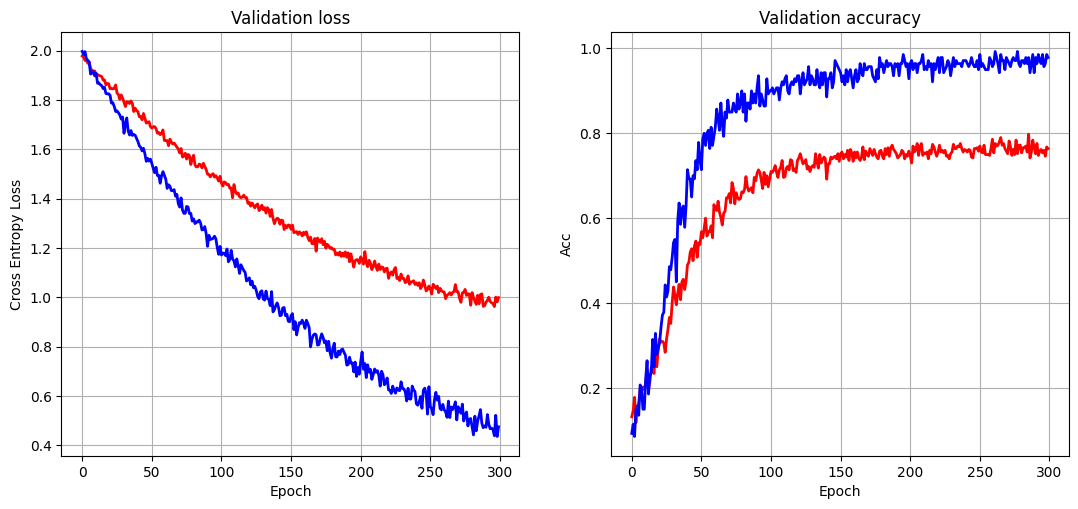

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red")
axs[0].plot(training_loss, linewidth=2, color="blue")
axs[0].set_title("Validation loss")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].set_xlabel("Epoch")
axs[0].grid()

axs[1].plot(validation_acc, linewidth=2, color="red")
axs[1].plot(training_acc, linewidth=2, color="blue")
axs[1].set_title("Validation accuracy")
axs[1].set_ylabel("Acc")
axs[1].set_xlabel("Epoch")
axs[1].grid()

plt.show()

学習後のfeatureがラベルごとにかたまっている見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

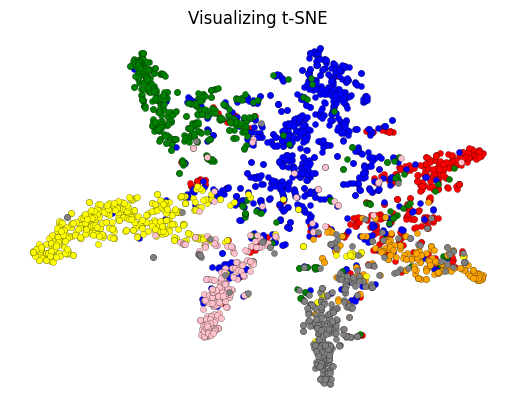

In [ ]:
visualize_embedding_tSNE(labels, y_pred, num_classes)